In [1]:
import torch
import gpytorch
from lodegp.LODEGP import LODEGP
import pprint
from sage.all import matrix, SR
from lodegp.kernels import LODE_Kernel, create_kernel_matrix_from_diagonal, differentiate_kernel_matrix, replace_sum_and_diff, translate_kernel_matrix_to_gpytorch_kernel

train_x = torch.linspace(int(0), int(1), int(10))
train_y = torch.linspace(int(0), int(1), int(10))
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(3, noise_constraint=gpytorch.constraints.Positive())
model = LODEGP(train_x, train_y, likelihood, int(3),  ODE_name="Heating")
print("A:")
A1 = model.A
pprint.pprint(model.A)
print("V:")
v1 = model.V
pprint.pprint(v1)
D, U, V = A1.smith_form()
print("D:")
pprint.pprint(D)
print("U:")
pprint.pprint(U)
print("MultiMatrixAusgabe:")
pprint.pprint(model.matrix_multiplication)
print("k:")
pprint.pprint(model.kernel_translation_dict)
print("V:")
pprint.pprint(model.V)
print("V.T:")
pprint.pprint(model.V.T)



A:
[x + a    -a    -1]
[   -b x + b     0]
V:
[                  1                   0             b + dx1]
[                  0                   0                   b]
[                  0                -1/b (a + b)*dx1 + dx1^2]
D:
[1 0 0]
[0 1 0]
U:
[     0 (-1)/b]
[     b  x + a]
MultiMatrixAusgabe:
[                            LODEGP_kernel_2*(b + dx1)*(b + dx2) + LODEGP_kernel_0                                                       LODEGP_kernel_2*(b + dx1)*b                                   ((a + b)*dx2 + dx2^2)*LODEGP_kernel_2*(b + dx1)]
[                                                      LODEGP_kernel_2*(b + dx2)*b                                                               LODEGP_kernel_2*b^2                                           ((a + b)*dx2 + dx2^2)*LODEGP_kernel_2*b]
[                                  ((a + b)*dx1 + dx1^2)*LODEGP_kernel_2*(b + dx2)                                           ((a + b)*dx1 + dx1^2)*LODEGP_kernel_2*b ((a + b)*dx1 + dx1^2)*((a + b)*dx

In [ ]:

import gpytorch 
from sage.all import *
import sage
#https://ask.sagemath.org/question/41204/getting-my-own-module-to-work-in-sage/
from sage.calculus.var import var
from lodegp.kernels import LODE_Kernel, create_kernel_matrix_from_diagonal, differentiate_kernel_matrix, replace_sum_and_diff, translate_kernel_matrix_to_gpytorch_kernel 
import pprint
import torch
from lodegp.LODEGP import LODEGP
import numpy as np
import pytest

torch.set_default_dtype(torch.float64)

def symmetry_check(model): 
    dx1, dx2 = var('dx1, dx2')
    symmetry_check_matrix = model.matrix_multiplication - matrix([[cell.substitute(dx1=dx2, dx2=dx1) for cell in row] for row in model.matrix_multiplication.T])
    # Symmetric up to numerical precision
    return all([all([cell < 1e-10 for cell in row]) for row in symmetry_check_matrix])

def eigval_check(model, train_x):
    covar_matrix = model(train_x).covariance_matrix
    eigvals = torch.linalg.eig(covar_matrix)[0]
    print("Eigenwerte (real):", eigvals)
    return all([eig.real > -1e-10 for eig in eigvals]), all([eig.imag < 1e-10 for eig in eigvals])


def test_heating():
    train_x = torch.linspace(0, 1, 10)
    train_y = torch.linspace(0, 1, 10)
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(3)
    model = LODEGP(train_x, train_y, likelihood, 3, ODE_name="Bipendulum", base_kernel="Matern_kernel_52")
    eig_positive, eig_real = eigval_check(model, train_x)

    assert eig_positive
    assert eig_real
#test_heating()


def test_three_tank():
    train_x = torch.linspace(0, 1, 10)
    train_y = torch.linspace(0, 1, 10)
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(5)
    model = LODEGP(train_x, train_y, likelihood, 5, ODE_name="Three tank", base_kernel="Matern_kernel_52")
    eig_positive, eig_real = eigval_check(model, train_x)
    
    assert eig_positive
    assert eig_real
    
test_three_tank()

Eigenwerte (real): tensor([ 3.6768e+01+0.0000e+00j,  2.7200e+01+0.0000e+00j,
         1.1928e+01+0.0000e+00j,  8.8404e+00+0.0000e+00j,
         4.7065e+00+0.0000e+00j,  3.6459e+00+0.0000e+00j,
         2.4695e+00+0.0000e+00j,  1.6629e+00+0.0000e+00j,
         1.1312e+00+0.0000e+00j,  5.4438e-01+0.0000e+00j,
         4.2671e-01+0.0000e+00j,  1.8524e-01+0.0000e+00j,
         1.6998e-01+0.0000e+00j,  9.2031e-02+0.0000e+00j,
         6.2982e-02+0.0000e+00j,  5.1544e-02+0.0000e+00j,
         3.2785e-02+0.0000e+00j,  2.7252e-02+0.0000e+00j,
         2.4337e-02+0.0000e+00j,  1.3501e-02+0.0000e+00j,
         7.5472e-03+0.0000e+00j,  4.7924e-03+0.0000e+00j,
         3.5527e-03+0.0000e+00j,  1.9282e-04+0.0000e+00j,
         6.5712e-05+0.0000e+00j,  5.7352e-05+0.0000e+00j,
         4.1188e-05+0.0000e+00j,  3.4007e-05+0.0000e+00j,
         3.0701e-05+0.0000e+00j,  2.7872e-05+0.0000e+00j,
         2.6953e-05+0.0000e+00j,  2.1263e-05+0.0000e+00j,
         2.4016e-05+0.0000e+00j,  2.4221e-05+0.0000e+

In [1]:
import gpytorch 
from sage.all import *
import sage
#https://ask.sagemath.org/question/41204/getting-my-own-module-to-work-in-sage/
from sage.calculus.var import var
from lodegp.kernels import *
import pprint
import torch
from lodegp.LODEGP import LODEGP
import numpy as np
from GP_helpers.helpers.util_functions import calculate_differential_equation_error_symbolic, calculate_differential_equation_error_numeric
import pytest
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)


def test_calculate_differential_equation_error_symbolic():
    train_x = torch.linspace(0, 1, 10)
    train_y = torch.linspace(0, 1, 10)
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(3)
    model = LODEGP(train_x, train_y, likelihood, 3, ODE_name="Bipendulum")
    ode_row_to_check = 1

    # Verify that the models output satisfies the given differential equation
    target_row = 2
    # Row is to be used with VkV' * A
    # Apply to second element of k
    model_cov_fkt_row = model.return_cov_fkt_row(target_row)
    diff_var = var("t2")
    differential_equation = [term.substitute(x=diff_var) for term in sage_eval(str(model.A[ode_row_to_check]), locals=model.sage_locals)]
    print(calculate_differential_equation_error_symbolic(model_cov_fkt_row, differential_equation, model.sage_locals, diff_var=diff_var)(t1=1, t2=1, signal_variance_2=1.0, lengthscale_2=1.0, a=1.0, b=1.0))


    # Column is to be used with A * VkV'
    # Apply to first element of k
    target_col = 0
    model_cov_fkt_col = model.return_cov_fkt_col(target_col)
    diff_var = var("t1")
    differential_equation = [term.substitute(x=diff_var) for term in sage_eval(str(model.A[ode_row_to_check]), locals=model.sage_locals)]
    print(calculate_differential_equation_error_symbolic(model_cov_fkt_col, differential_equation, model.sage_locals, diff_var=diff_var)(t1=1, t2=1, signal_variance_2=1.0, lengthscale_2=1.0, a=1.0, b=1.0))



test_calculate_differential_equation_error_symbolic()

-5.684341886080802e-14
0


Lokale Werte: {signal_variance_1: 1.0, lengthscale_1: 1.0}
t2
unable to simplify to float approximation
Numerischer ODE-Fehler: tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -

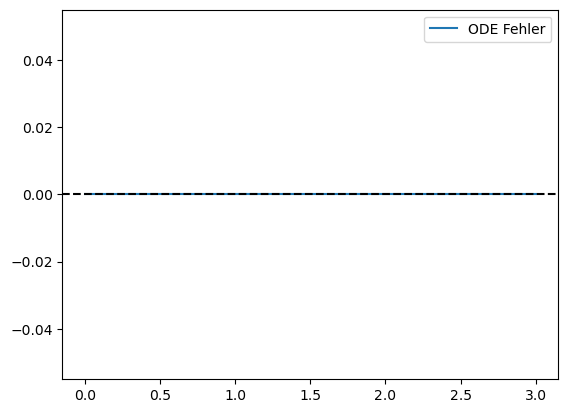

In [ ]:
def test_calculate_differential_equation_error_numeric():


    # Trainingsdaten basierend auf e^x
    train_x = torch.linspace(0, 1, 10)
    train_y = torch.exp(train_x)  # e^x
    # packen wir in 2D (z.B. y und y')
    train_y = torch.stack([train_y, train_y], -1)  

    # Likelihood und Modell
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
        2, noise_constraint=gpytorch.constraints.Positive()
    )
    model = LODEGP(train_x, train_y, likelihood, 2, ODE_name="Minimal")

    # Lokale Werte
    local_values = model.prepare_numeric_ode_satisfaction_check()
    print("Lokale Werte:", local_values)

    # Differentialgleichung vorbereiten
    target_row = 1
    ode_row_to_check = 0
    diff_var = var("t2")
    differential_eq = [
        term.substitute(x=diff_var)
        for term in sage_eval(str(model.A[ode_row_to_check]), locals=model.sage_locals)
    ]

    model.eval()
    likelihood.eval()
    sage_locals = model.sage_locals
    data = torch.linspace(0, 3, 200)  # Testbereich etwas größer

    # Daten generierende Funktion: Modell-Ausgabe
    data_generating_functions = lambda x: model(x).mean

    # Numerischen ODE-Fehler berechnen
    with gpytorch.settings.prior_mode(True):
        result = calculate_differential_equation_error_numeric(
            differential_eq,
            sage_locals,
            data_generating_functions,        
            data,
            locals_values=local_values
        )

    print("Numerischer ODE-Fehler:", result)
    plt.plot(data, result.detach(), label="ODE Fehler")
    plt.axhline(0, color="black", linestyle="--")
    plt.legend()
    plt.show()

test_calculate_differential_equation_error_numeric()


